In [2]:
import pandas as pd
import xgboost as xgb
import random
import joblib
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from scipy.stats import mstats, uniform, randint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('new_isc_04.csv')

In [4]:
id_column = 'id'
df = df.drop(id_column, axis=1)

In [5]:
target = 'churn'

In [6]:
bin_features = ['is_tv_subscriber', 'is_movie_package_subscriber']
non_bin_features = df.columns.drop(bin_features + [target])

In [7]:
X = df.drop(columns=[target])
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [10]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'feature_columns.pkl')

['feature_columns.pkl']

In [11]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
hgbc_model = HistGradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

In [13]:
def models_cross_validate(model, X_train_scaled, y_train, cv=5):

    scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = {}
    for score in scoring:
        results[score] = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring=score)
    return results

xgb_cv_results = models_cross_validate(xgb_model, X_train_scaled, y_train)
print(xgb_cv_results)

hgbc_cv_results = models_cross_validate(hgbc_model, X_train_scaled, y_train)
print(hgbc_cv_results)

{'accuracy': array([0.94213284, 0.93887751, 0.94351439]), 'precision': array([0.95625692, 0.95578572, 0.95737378]), 'recall': array([0.93848495, 0.93282609, 0.9398913 ]), 'f1': array([0.94728759, 0.94416635, 0.948552  ])}
{'accuracy': array([0.94285542, 0.93990124, 0.94429724]), 'precision': array([0.957834  , 0.9573946 , 0.95875374]), 'recall': array([0.9381589 , 0.93304348, 0.9398913 ]), 'f1': array([0.94789436, 0.9450622 , 0.94922883])}


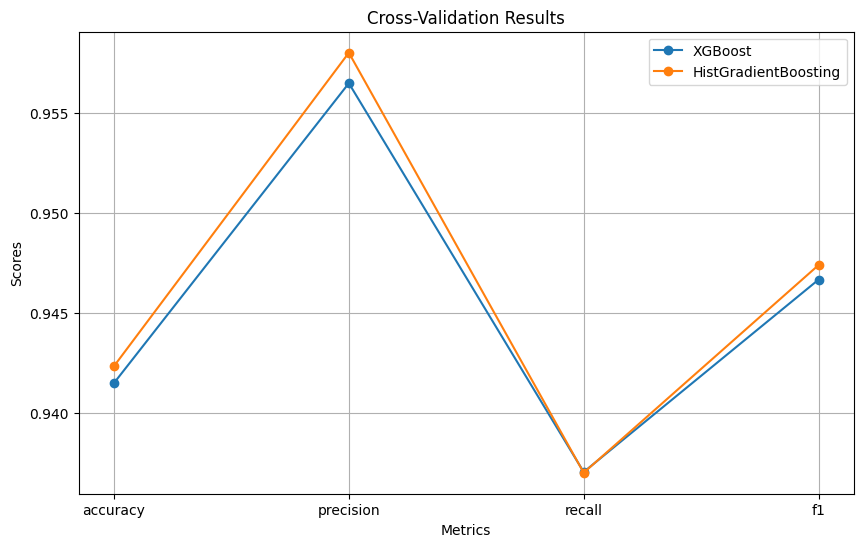

In [14]:
def cv_line_plot(xgb_cv_results, hgbc_cv_results):

    metrics = ['accuracy', 'precision', 'recall', 'f1']
    xgb_means = [np.mean(xgb_cv_results[metric]) for metric in metrics]
    hgb_means = [np.mean(hgbc_cv_results[metric]) for metric in metrics]

    plt.figure(figsize=(10, 6))
    plt.plot(metrics, xgb_means, marker='o', label='XGBoost')
    plt.plot(metrics, hgb_means, marker='o', label='HistGradientBoosting')

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('Cross-Validation Results')
    plt.legend()
    plt.grid(True)
    plt.show()

cv_line_plot(xgb_cv_results, hgbc_cv_results)

In [15]:
param_dist_hgbc = {
    'max_iter': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 20),
    'min_samples_leaf': randint(20, 100),
    'max_leaf_nodes': randint(20, 100),
    'l2_regularization': uniform(0, 2.0)
}

In [16]:
param_dist_xgb = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 2.0),
    'reg_lambda': uniform(0, 2.0)
}


In [17]:
xgb_model = XGBClassifier(random_state=42)
hgbc_model = HistGradientBoostingClassifier(random_state=42)

In [18]:
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search_hgbc = RandomizedSearchCV(
    estimator=hgbc_model,
    param_distributions=param_dist_hgbc,
    n_iter=10,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [19]:
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_

random_search_hgbc.fit(X_train_scaled, y_train)
best_hgbc_model = random_search_hgbc.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [20]:
print("Najlepsze parametry XGBoost:", random_search_xgb.best_params_)
print("Najlepsze parametry HistGradientBoosting:", random_search_hgbc.best_params_)

Najlepsze parametry XGBoost: {'colsample_bytree': 0.8909087983425683, 'learning_rate': 0.1079622306417506, 'max_depth': 8, 'n_estimators': 314, 'reg_alpha': 1.0416685200516473, 'reg_lambda': 1.9223440486986982, 'subsample': 0.9378135394712606}
Najlepsze parametry HistGradientBoosting: {'l2_regularization': 0.31203728088487304, 'learning_rate': 0.05679835610086079, 'max_depth': 13, 'max_iter': 187, 'max_leaf_nodes': 43, 'min_samples_leaf': 22}


In [21]:
xgb_predictions = best_xgb_model.predict(X_test_scaled)
hgbc_predictions = best_hgbc_model.predict(X_test_scaled)

In [22]:
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

hgbc_accuracy = accuracy_score(y_test, hgbc_predictions)
hgbc_precision = precision_score(y_test, hgbc_predictions)
hgbc_recall = recall_score(y_test, hgbc_predictions)
hgbc_f1 = f1_score(y_test, hgbc_predictions)

In [23]:
print("XGBoost Model Metrics:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")

print("\nHistGradientBoosting Model Metrics:")
print(f"Accuracy: {hgbc_accuracy:.4f}")
print(f"Precision: {hgbc_precision:.4f}")
print(f"Recall: {hgbc_recall:.4f}")
print(f"F1 Score: {hgbc_f1:.4f}")

XGBoost Model Metrics:
Accuracy: 0.9450
Precision: 0.9565
Recall: 0.9436
F1 Score: 0.9500

HistGradientBoosting Model Metrics:
Accuracy: 0.9432
Precision: 0.9560
Recall: 0.9409
F1 Score: 0.9484


In [24]:
joblib.dump(best_hgbc_model, 'best_hgbc_model.pkl')
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

In [25]:
def predict_customer_churn(customer_data):

    # Sprawdzenie, czy wszystkie wymagane cechy są obecne
    required_features = set(X_train_scaled.columns)
    provided_features = set(customer_data.index if isinstance(customer_data, pd.Series) else customer_data.keys())

    if not required_features.issubset(provided_features):
        missing_features = required_features - provided_features
        raise ValueError(f"Missing values: {missing_features}")

    # Przygotowanie danych klienta
    customer_df = pd.DataFrame([customer_data])
    customer_df = customer_df[X_train.columns]

    # Skalowanie danych
    customer_scaled = pd.DataFrame(scaler.transform(customer_df), columns=X_train.columns)

    # Predykcje
    hgbc_predictions = best_hgbc_model.predict(customer_scaled)
    xgb_predictions = best_xgb_model.predict(customer_scaled)

    hgbc_prob = best_hgbc_model.predict_proba(customer_scaled)[0][1]
    xgb_prob = best_xgb_model.predict_proba(customer_scaled)[0][1]

    # Przygotowanie wyników
    results = {
        'HistGradientBoosting': {
            'prediction': 'High' if hgbc_predictions[0] else 'Low',
            'probability': float(hgbc_prob)
        },
        'XGBoost': {
            'prediction': 'High' if xgb_predictions[0] else 'Low',
            'probability': float(xgb_prob)
        }
    }

    return results

# Wczytanie przykładowych danych z pliku CSV
try:
    sample_data = pd.read_csv('secret_isc_04.csv', nrows=10)
    print(f"{len(sample_data)} customers loaded.")
except FileNotFoundError:
    print("File 'secret_isc_04.csv' not found.")
    exit()

# Testowanie funkcji na przykładowych danych z pliku CSV
for index, customer in sample_data.iterrows():
    try:
        prediction_results = predict_customer_churn(customer)
        print(f"\nPrediction results for a customer {index + 1} (ID: {customer.get('id', 'N/A')}):")
        print(prediction_results)
    except ValueError as e:
        print(f"Error for a customer {index + 1}: {e}")

10 customers loaded.

Prediction results for a customer 1 (ID: 111306.0):
{'HistGradientBoosting': {'prediction': 'Low', 'probability': 0.022989225305902857}, 'XGBoost': {'prediction': 'Low', 'probability': 0.011661949567496777}}

Prediction results for a customer 2 (ID: 1107384.0):
{'HistGradientBoosting': {'prediction': 'High', 'probability': 0.956073350305662}, 'XGBoost': {'prediction': 'High', 'probability': 0.9642027020454407}}

Prediction results for a customer 3 (ID: 1635337.0):
{'HistGradientBoosting': {'prediction': 'Low', 'probability': 0.014534901647679203}, 'XGBoost': {'prediction': 'Low', 'probability': 0.004695126786828041}}

Prediction results for a customer 4 (ID: 17283.0):
{'HistGradientBoosting': {'prediction': 'Low', 'probability': 0.014052712109939493}, 'XGBoost': {'prediction': 'Low', 'probability': 0.011601041071116924}}

Prediction results for a customer 5 (ID: 1229527.0):
{'HistGradientBoosting': {'prediction': 'Low', 'probability': 0.06286959554156779}, 'XGBoos

In [26]:
def visualize_results(model_name, predictions, true_labels):
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

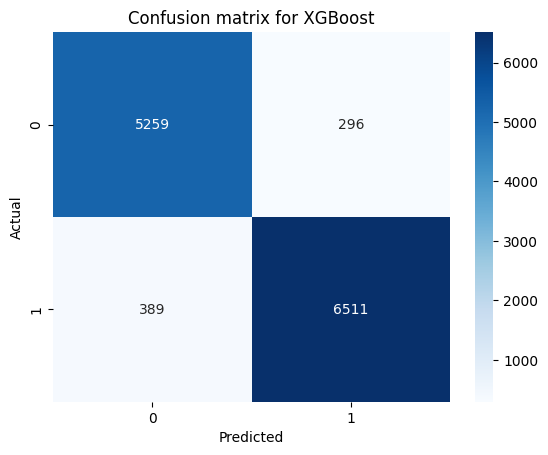

In [27]:
xgb_predictions = best_xgb_model.predict(X_test_scaled)
visualize_results('XGBoost', xgb_predictions, y_test)

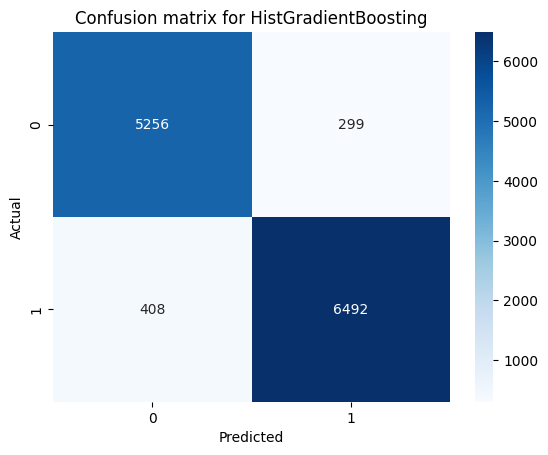

In [28]:
hgbc_predictions = best_hgbc_model.predict(X_test_scaled)
visualize_results('HistGradientBoosting', hgbc_predictions, y_test)

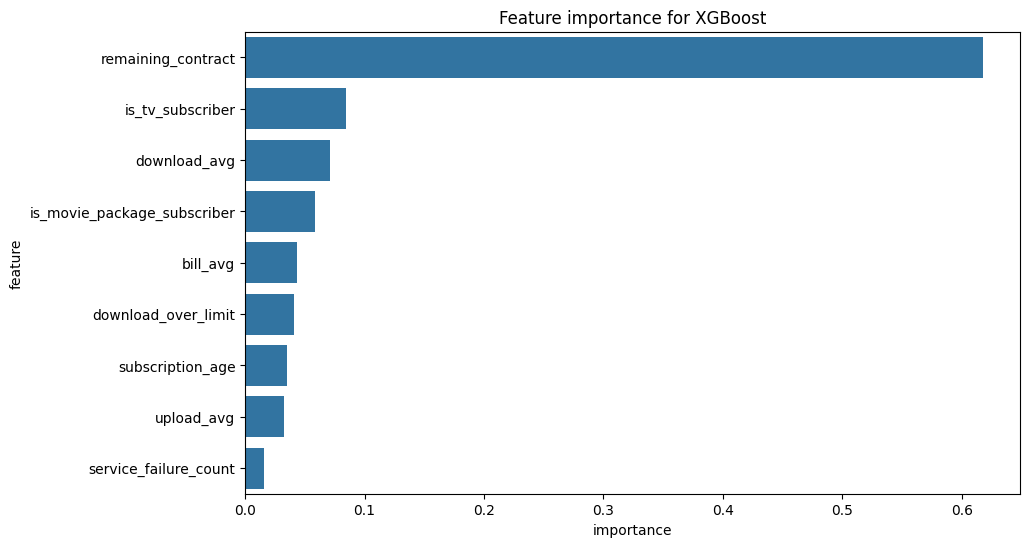

In [29]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': best_xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature importance for XGBoost')
plt.show()

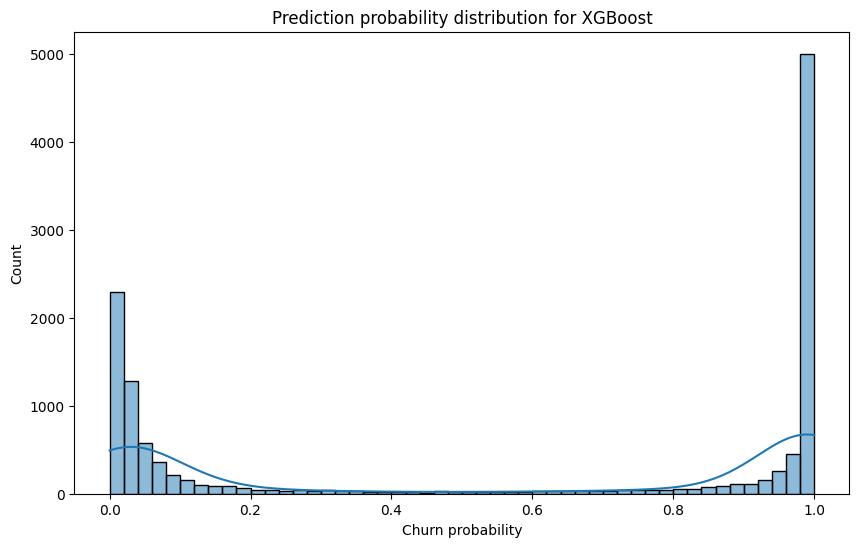

In [30]:
xgb_probs = best_xgb_model.predict_proba(X_test_scaled)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(xgb_probs, bins=50, kde=True)
plt.title('Prediction probability distribution for XGBoost')
plt.xlabel('Churn probability')
plt.show()

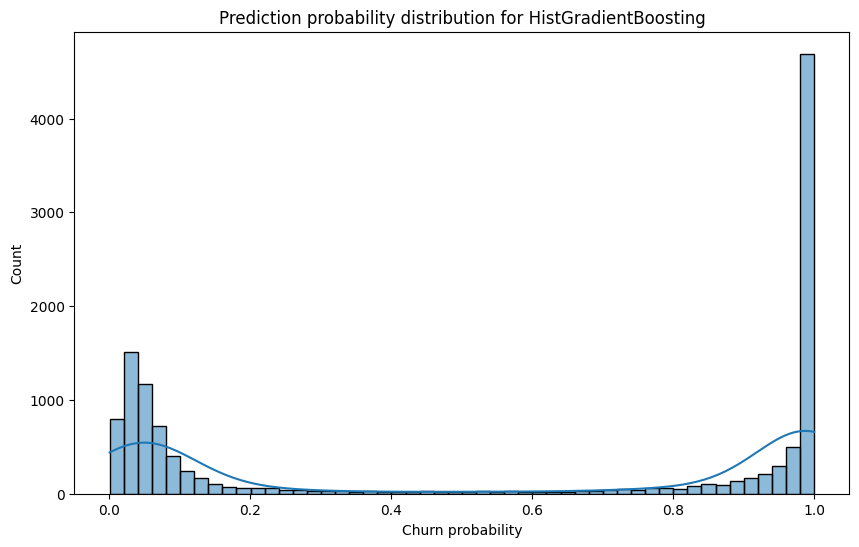

In [31]:
hgbc_probs = best_hgbc_model.predict_proba(X_test_scaled)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(hgbc_probs, bins=50, kde=True)
plt.title('Prediction probability distribution for HistGradientBoosting')
plt.xlabel('Churn probability')
plt.show()



---



---



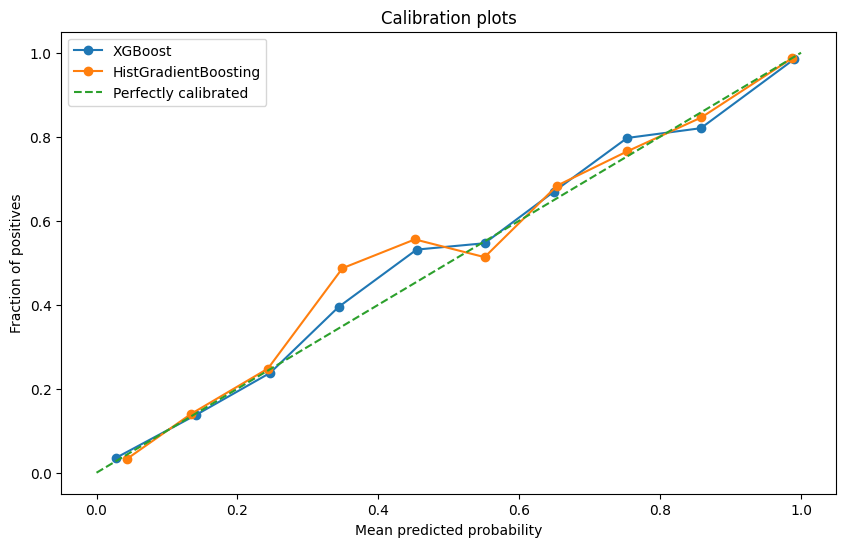

In [32]:
xgb_prob_true, xgb_prob_predictions = calibration_curve(y_test, best_xgb_model.predict_proba(X_test_scaled)[:, 1], n_bins=10)

hgbc_prob_true, hgbc_prob_predictions = calibration_curve(y_test, best_hgbc_model.predict_proba(X_test_scaled)[:, 1], n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(xgb_prob_predictions, xgb_prob_true, marker='o', label='XGBoost')
plt.plot(hgbc_prob_predictions, hgbc_prob_true, marker='o', label='HistGradientBoosting')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plots')
plt.legend()
plt.show()

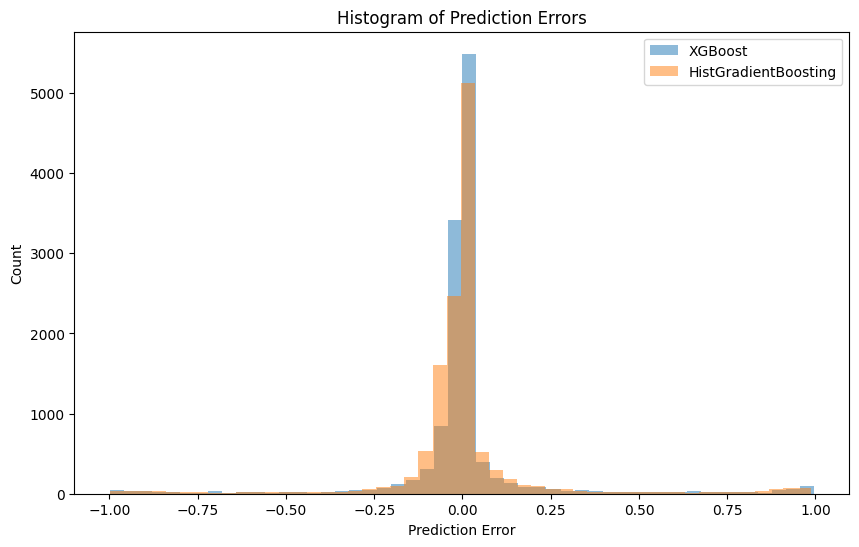

In [33]:
xgb_errors = y_test - best_xgb_model.predict_proba(X_test_scaled)[:, 1]
hgbc_errors = y_test - best_hgbc_model.predict_proba(X_test_scaled)[:, 1]

plt.figure(figsize=(10, 6))
plt.hist(xgb_errors, bins=50, alpha=0.5, label='XGBoost')
plt.hist(hgbc_errors, bins=50, alpha=0.5, label='HistGradientBoosting')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Histogram of Prediction Errors')
plt.legend()
plt.show()

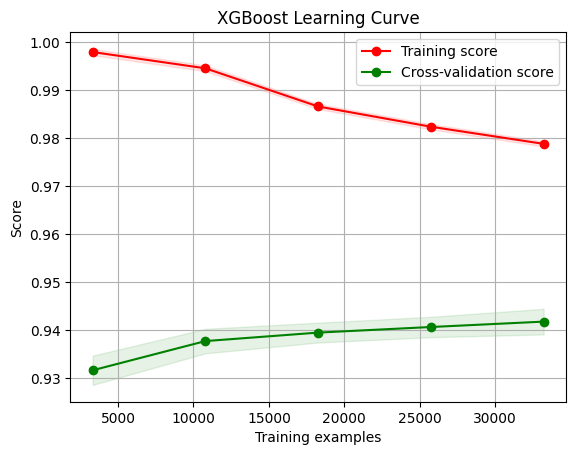

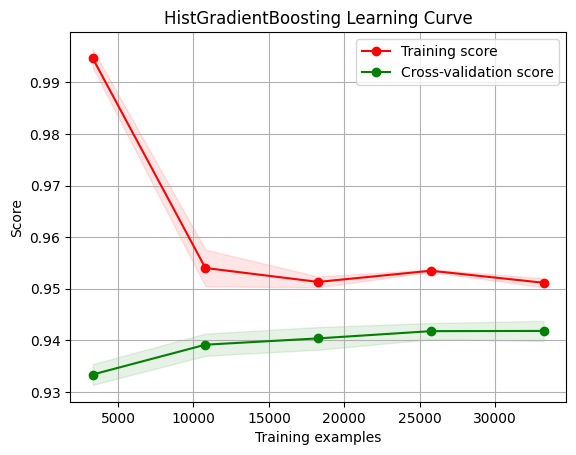

In [34]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(best_xgb_model, "XGBoost Learning Curve", X_train_scaled, y_train, cv=skf, n_jobs=-1)
plot_learning_curve(best_hgbc_model, "HistGradientBoosting Learning Curve", X_train_scaled, y_train, cv=skf, n_jobs=-1)

plt.show()